In [1]:
""" ====================================================================================
Import necessary libraries     
"""
import pandas as pd
import numpy as np


from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LassoCV
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

import graphviz
import matplotlib.pyplot as plt

In [2]:
"""
==================================================================
1. Data Exploration and Preprocessing
    - Have a basic understanding of what the data look like?
    - Flowback, PW, and FracingFluid are suggested to be sourced from DrillFluid, Brine, and Injection fluids; and the remaining from rocks.
    - Process the data to express Flowback, PW, and FracingFluid as proportions of DrillFluid, Brine, Injection, and Rock.
"""
full = pd.read_csv("./data/full_data.csv", encoding = "ISO-8859-1")
print("The dataset has {} attributes".format(full.shape[1]))
print("There are {} types of water in this dataset:".format(full.Type_new.nunique()))
print("{}".format(full.Type_new.unique()))

The dataset has 104 attributes
There are 6 types of water in this dataset:
['Flowback' 'PW' 'DrillFluid' 'Brine' 'FracingFluid' 'Injection']


In [3]:
full.fillna(0, inplace=True)
full.head()

,Unnamed: 0,County,Name,RWC,Type,Amount,Unit,Waste type,Time,time2,...,SO4 (mg/l),K (mg/l),DOC (mg/l),TOC (mg/l),F (mg/l),P_total (mg/l),N_total (mg/l),Al (ppm),S (ppm),type_mark
0,0,BRADFORD,Bacorn bra pad,805,Flowback,398496.0,gal,liquid,42668,10/25/16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5
1,1,BRADFORD,Bacorn bra pad,802,PW,1035125.0,gal,liquid,42718,12/14/16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4
2,2,BRADFORD,BIM BRA PAD,802,PW,39900.0,gal,liquid,42718,12/14/16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4
3,3,BRADFORD,JES BRA PAD,805,Flowback,9156.0,gal,liquid,42696,11/22/16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5
4,4,BRADFORD,JES BRA PAD,802,PW,84966.0,gal,liquid,42718,12/14/16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4


In [4]:
"Store the 6 types of waters into separate dataframes for further exploration"
brine = full[full.Type_new == 'Brine'].reset_index()
injection = full[full.Type_new == 'Injection'].reset_index()
drill = full[full.Type_new == 'DrillFluid'].reset_index()
pw = full[full.Type_new == 'PW'].reset_index()
flowback = full[full.Type_new == 'Flowback'].reset_index()
fracing = full[full.Type_new == 'FracingFluid'].reset_index()

print("There are:\n  {} records of brine,\n  {} records of injection fluid,\n  {} records of drill fluid,\n  {} records of flowback water,\n  {} records of late fracking fluid,\n  {} records of produced water."
      .format(brine.shape[0], injection.shape[0], drill.shape[0], flowback.shape[0], fracing.shape[0], pw.shape[0]))


There are:
  70 records of brine,
  21 records of injection fluid,
  16 records of drill fluid,
  476 records of flowback water,
  45 records of late fracking fluid,
  556 records of produced water.


In [5]:
"Solve for Flowback, PW, and FracingFluid as proportions comprised of DrillFluid, Brine, and Injection fluid"
def solve_brine_injec_drill(file, mm, nn, percent):
    """
    For a given fluid type, two input elements were used to help resolving the proportions of each component - DrillFluid, Brine, and Injection fluid
    
    INPUT:
        file - the dataframe containing target fluid type (e.g. flowback, fracing, pw)
        mm - one element name used together with 'nn' in solving for fluid compositions (e.g. Br)
        nn - a second element name used together with 'mm' in solving for fluid compositions (e.g. Cl)
        percent - the percentage of the element 'nn' determined to be explained by the sources of DrillFluid, Brine, and Injection fluid
    OUTPUT:
        file - the input target fluid type with additional columns of resolved proportions of DrillFluid, Brine, and Injection fluid
    """
    
    "Define the column names for use in the for-loop"
    name1 = mm+' (mg/l)'
    name2 = nn+' (mg/l)'
    name1_br = '%'+mm+'_brine'
    name1_inj = '%'+mm+'_injec'
    name1_drill = '%'+mm+'_drill'
    name1_rock = '%'+mm+'_rock'
    name2_br = '%'+nn+'_brine'
    name2_inj = '%'+nn+'_injec'
    name2_drill = '%'+nn+'_drill'
    name2_rock = '%'+nn+'_rock'
    
    for i in range(0,file.shape[0]):
        """1. Use rec_*** to record three locations for each source fluids"""
        "set the default dist as 20,21,22; so the locations are within comparable range and are also none-zeros"
        rec_brine = pd.DataFrame({'index':[0,0,0],'dist':[20,21,22],'wt':[0,0,0]})
        rec_injec = pd.DataFrame({'index':[0,0,0],'dist':[20,21,22],'wt':[0,0,0]})
        rec_drill = pd.DataFrame({'index':[0,0,0],'dist':[20,21,22],'wt':[0,0,0]})
        "Fill out and update the closest three locations for each of the three source fluids"
        if file.loc[i,'Well_latitude']>10 and file.loc[i,'Well_longitude']<-10:
            lat = file.loc[i,'Well_latitude']
            lon = file.loc[i,'Well_longitude']
            for a in range(0,brine.shape[0]):
                if brine.loc[a,'Well_latitude']>10 and brine.loc[a,'Well_longitude'] <-10:
                    if (file.loc[i,'year'] < 2011 and brine.loc[a,'year'] == 2010) or (file.loc[i,'year'] > 2011 and brine.loc[a,'year'] > 2010):
                        lat1 = brine.loc[a,'Well_latitude']
                        lon1 = brine.loc[a,'Well_longitude']
                        dist_a = np.sqrt((lat1-lat)**2+(lon1-lon)**2)
                        idxtemp_a = rec_brine.dist.idxmax()
                        distemp_a = rec_brine.dist.max()
                        if distemp_a > dist_a:
                            rec_brine.loc[idxtemp_a,'index'] = a
                            rec_brine.loc[idxtemp_a,'dist'] = dist_a
            for b in range(0,injection.shape[0]):
                if injection.loc[b,'Well_latitude']>10 and injection.loc[b,'Well_longitude']<-10:
                    lat2 = injection.loc[b,'Well_latitude']
                    lon2 = injection.loc[b,'Well_longitude']
                    dist_b = np.sqrt((lat2-lat)**2+(lon2-lon)**2)
                    idxtemp_b = rec_injec.dist.idxmax()
                    distemp_b = rec_injec.dist.max()
                    if distemp_b > dist_b:
                        rec_injec.loc[idxtemp_b,'index'] = b
                        rec_injec.loc[idxtemp_b,'dist'] = dist_b
            for c in range(0,drill.shape[0]):
                if drill.loc[c,'Well_latitude']>10 and drill.loc[c,'Well_longitude']<-10:
                    lat3 = drill.loc[c,'Well_latitude']
                    lon3 = drill.loc[c,'Well_longitude']
                    dist_c = np.sqrt((lat3-lat)**2+(lon3-lon)**2)
                    idxtemp_c = rec_drill.dist.idxmax()
                    distemp_c = rec_drill.dist.max()
                    if distemp_c > dist_c:
                        rec_drill.loc[idxtemp_c,'index'] = c
                        rec_drill.loc[idxtemp_c,'dist'] = dist_c

            """2. Generate the weighted value for each source fluid"""            
            sum_brine = rec_brine.dist.sum()
            rec_brine.loc[0,'wt'] = (sum_brine+0.0003)/(rec_brine.loc[0,'dist']+0.0001)
            rec_brine.loc[1,'wt'] = (sum_brine+0.0003)/(rec_brine.loc[1,'dist']+0.0001)
            rec_brine.loc[2,'wt'] = (sum_brine+0.0003)/(rec_brine.loc[2,'dist']+0.0001)
            sum_br_wt = rec_brine.wt.sum()
            rec_brine.loc[0,'wt'] = (rec_brine.loc[0,'wt']+0.01)/(sum_br_wt+0.03)
            rec_brine.loc[1,'wt'] = (rec_brine.loc[1,'wt']+0.01)/(sum_br_wt+0.03)
            rec_brine.loc[2,'wt'] = (rec_brine.loc[2,'wt']+0.01)/(sum_br_wt+0.03)

            sum_injec = rec_injec.dist.sum()
            rec_injec.loc[0,'wt'] = (sum_injec+0.0003)/(rec_injec.loc[0,'dist']+0.0001)
            rec_injec.loc[1,'wt'] = (sum_injec+0.0003)/(rec_injec.loc[1,'dist']+0.0001)
            rec_injec.loc[2,'wt'] = (sum_injec+0.0003)/(rec_injec.loc[2,'dist']+0.0001)
            sum_in_wt = rec_injec.wt.sum()
            rec_injec.loc[0,'wt'] = (rec_injec.loc[0,'wt']+0.01)/(sum_in_wt+0.03)
            rec_injec.loc[1,'wt'] = (rec_injec.loc[1,'wt']+0.01)/(sum_in_wt+0.03)
            rec_injec.loc[2,'wt'] = (rec_injec.loc[2,'wt']+0.01)/(sum_in_wt+0.03)

            sum_drill = rec_drill.dist.sum()
            rec_drill.loc[0,'wt'] = (sum_drill+0.0003)/(rec_drill.loc[0,'dist']+0.0001)
            rec_drill.loc[1,'wt'] = (sum_drill+0.0003)/(rec_drill.loc[1,'dist']+0.0001)
            rec_drill.loc[2,'wt'] = (sum_drill+0.0003)/(rec_drill.loc[2,'dist']+0.0001)
            sum_dr_wt = rec_drill.wt.sum()
            rec_drill.loc[0,'wt'] = rec_drill.loc[0,'wt']/sum_dr_wt
            rec_drill.loc[1,'wt'] = rec_drill.loc[1,'wt']/sum_dr_wt
            rec_drill.loc[2,'wt'] = rec_drill.loc[2,'wt']/sum_dr_wt

            """3. Record the weight and index of each source fluid to the target fluid"""
            file.loc[i,'brine_idx1'] = rec_brine.loc[0,'index']
            file.loc[i,'brine_wt1'] = rec_brine.loc[0,'wt']
            file.loc[i,'brine_idx2'] = rec_brine.loc[1,'index']
            file.loc[i,'brine_wt2'] = rec_brine.loc[1,'wt']
            file.loc[i,'brine_idx3'] = rec_brine.loc[2,'index']
            file.loc[i,'brine_wt3'] = rec_brine.loc[2,'wt']
            file.loc[i,'injec_idx1'] = rec_injec.loc[0,'index']
            file.loc[i,'injec_wt1'] = rec_injec.loc[0,'wt']
            file.loc[i,'injec_idx2'] = rec_injec.loc[1,'index']
            file.loc[i,'injec_wt2'] = rec_injec.loc[1,'wt']
            file.loc[i,'injec_idx3'] = rec_injec.loc[2,'index']
            file.loc[i,'injec_wt3'] = rec_injec.loc[2,'wt']
            file.loc[i,'drill_idx1'] = rec_drill.loc[0,'index']
            file.loc[i,'drill_wt1'] = rec_drill.loc[0,'wt']
            file.loc[i,'drill_idx2'] = rec_drill.loc[1,'index']
            file.loc[i,'drill_wt2'] = rec_drill.loc[1,'wt']
            file.loc[i,'drill_idx3'] = rec_drill.loc[2,'index']
            file.loc[i,'drill_wt3'] = rec_drill.loc[2,'wt']

            """4. Form equations: 
                - 1st row is mm (e.g. Br), 1st column is brine, 
                - 2nd row is nn (e.g. Cl), 2nd column is injection fluid, 
                - 3rd row is ratios, 3rd column is drill fluid""" 
            """Element pair combination used in this work:"
                Br*x1 + Br*x2 + Br*x3 = Br_known
                Cl*x1 + Cl*x2 + Cl*x3 = Cl_known*percent
                x1+x2+x3 = 1"""
            br1 = brine.loc[rec_brine.loc[0,'index'],name1]*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],name1]*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],name1]*rec_brine.loc[2,'wt']
            br2 = injection.loc[rec_injec.loc[0,'index'],name1]*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],name1]*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],name1]*rec_injec.loc[2,'wt']
            br3 = drill.loc[rec_drill.loc[0,'index'],name1]*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],name1]*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],name1]*rec_drill.loc[2,'wt']
            cl1 = brine.loc[rec_brine.loc[0,'index'],name2]*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],name2]*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],name2]*rec_brine.loc[2,'wt']
            cl2 = injection.loc[rec_injec.loc[0,'index'],name2]*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],name2]*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],name2]*rec_injec.loc[2,'wt']
            cl3 = drill.loc[rec_drill.loc[0,'index'],name2]*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],name2]*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],name2]*rec_drill.loc[2,'wt']
            a = np.array([[br1,br2,br3],[cl1,cl2,cl3],[1,1,1]])
            param2 = file.loc[i,name2]*percent
            b = np.array([file.loc[i,name1],param2,1])
            n = len(b)
            fun = lambda x: np.linalg.norm(np.dot(a,x)-b)
            sol = minimize(fun, np.zeros(n), method = 'L-BFGS-B', bounds=[(0.,1.) for x in range(n)])
            
            file.loc[i,'brine_x'] = sol['x'][0]
            file.loc[i,'injec_x'] = sol['x'][1]
            file.loc[i,'drill_x'] = sol['x'][2]
            
            """5. Calculate % of chemical concentration explained by each proportion of source fluid"""
            "The % of concentration coming from rock source can be expressed as 1 - source(brine + injec + drill)"
            if file.loc[i,'B (mg/l)'] > 0:
                file.loc[i,'%B_brine'] = (brine.loc[rec_brine.loc[0,'index'],'B (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'B (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'B (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'B (mg/l)']
                file.loc[i,'%B_injec'] = (injection.loc[rec_injec.loc[0,'index'],'B (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'B (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'B (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'B (mg/l)']
                file.loc[i,'%B_drill'] = (drill.loc[rec_drill.loc[0,'index'],'B (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'B (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'B (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'B (mg/l)']
                file.loc[i,'%B_rock'] = 1-file.loc[i,'%B_brine']-file.loc[i,'%B_injec']-file.loc[i,'%B_drill']
            if file.loc[i,'Br (mg/l)'] > 0:
                file.loc[i,'%Br_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Br (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Br (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Br (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Br (mg/l)']
                file.loc[i,'%Br_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Br (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Br (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Br (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Br (mg/l)']
                file.loc[i,'%Br_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Br (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Br (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Br (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Br (mg/l)']
                file.loc[i,'%Br_rock'] = 1-file.loc[i,'%Br_brine']-file.loc[i,'%Br_injec']-file.loc[i,'%Br_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Br_brine'] = file.loc[i,'%Br_brine']*file.loc[i,'Br (mg/l)']
                file.loc[i, 'Br_drill'] = file.loc[i,'%Br_drill']*file.loc[i,'Br (mg/l)']
                file.loc[i, 'Br_rock'] = file.loc[i,'%Br_rock']*file.loc[i,'Br (mg/l)']
            if file.loc[i,'Cl (mg/l)'] > 0:
                file.loc[i,'%Cl_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Cl (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Cl (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Cl (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Cl (mg/l)']
                file.loc[i,'%Cl_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Cl (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Cl (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Cl (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Cl (mg/l)']
                file.loc[i,'%Cl_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Cl (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Cl (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Cl (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Cl (mg/l)']
                file.loc[i,'%Cl_rock'] = 1-file.loc[i,'%Cl_brine']-file.loc[i,'%Cl_injec']-file.loc[i,'%Cl_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Cl_brine'] = file.loc[i,'%Cl_brine']*file.loc[i,'Cl (mg/l)']
                file.loc[i, 'Cl_drill'] = file.loc[i,'%Cl_drill']*file.loc[i,'Cl (mg/l)']
                file.loc[i, 'Cl_rock'] = file.loc[i,'%Cl_rock']*file.loc[i,'Cl (mg/l)']
            if file.loc[i,'Ca (mg/l)'] > 0.1:
                file.loc[i,'%Ca_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Ca (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Ca (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Ca (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Ca (mg/l)']
                file.loc[i,'%Ca_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Ca (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Ca (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Ca (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Ca (mg/l)']
                file.loc[i,'%Ca_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Ca (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Ca (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Ca (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Ca (mg/l)']
                file.loc[i,'%Ca_rock'] = 1-file.loc[i,'%Ca_brine']-file.loc[i,'%Ca_injec']-file.loc[i,'%Ca_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Ca_brine'] = file.loc[i,'%Ca_brine']*file.loc[i,'Ca (mg/l)']
                file.loc[i, 'Ca_drill'] = file.loc[i,'%Ca_drill']*file.loc[i,'Ca (mg/l)']
                file.loc[i, 'Ca_rock'] = file.loc[i,'%Ca_rock']*file.loc[i,'Ca (mg/l)']
            if file.loc[i,'Fe (mg/l)'] > 0:
                file.loc[i,'%Fe_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Fe (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Fe (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Fe (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Fe (mg/l)']
                file.loc[i,'%Fe_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Fe (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Fe (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Fe (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Fe (mg/l)']
                file.loc[i,'%Fe_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Fe (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Fe (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Fe (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Fe (mg/l)']
                file.loc[i,'%Fe_rock'] = 1-file.loc[i,'%Fe_brine']-file.loc[i,'%Fe_injec']-file.loc[i,'%Fe_drill']
            if file.loc[i,'Li (mg/l)'] > 0:
                file.loc[i,'%Li_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Li (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Li (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Li (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Li (mg/l)']
                file.loc[i,'%Li_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Li (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Li (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Li (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Li (mg/l)']
                file.loc[i,'%Li_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Li (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Li (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Li (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Li (mg/l)']
                file.loc[i,'%Li_rock'] = 1-file.loc[i,'%Li_brine']-file.loc[i,'%Li_injec']-file.loc[i,'%Li_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Li_brine'] = file.loc[i,'%Li_brine']*file.loc[i,'Li (mg/l)']
                file.loc[i, 'Li_drill'] = file.loc[i,'%Li_drill']*file.loc[i,'Li (mg/l)']
                file.loc[i, 'Li_rock'] = file.loc[i,'%Li_rock']*file.loc[i,'Li (mg/l)']
            if file.loc[i,'Mg (mg/l)'] > 0.1:
                file.loc[i,'%Mg_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Mg (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Mg (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Mg (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Mg (mg/l)']
                file.loc[i,'%Mg_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Mg (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Mg (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Mg (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Mg (mg/l)']
                file.loc[i,'%Mg_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Mg (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Mg (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Mg (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Mg (mg/l)']
                file.loc[i,'%Mg_rock'] = 1-file.loc[i,'%Mg_brine']-file.loc[i,'%Mg_injec']-file.loc[i,'%Mg_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Mg_brine'] = file.loc[i,'%Mg_brine']*file.loc[i,'Mg (mg/l)']
                file.loc[i, 'Mg_drill'] = file.loc[i,'%Mg_drill']*file.loc[i,'Mg (mg/l)']
                file.loc[i, 'Mg_rock'] = file.loc[i,'%Mg_rock']*file.loc[i,'Mg (mg/l)']
            if file.loc[i,'Mn (mg/l)'] > 0:
                file.loc[i,'%Mn_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Mn (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Mn (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Mn (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Mn (mg/l)']
                file.loc[i,'%Mn_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Mn (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Mn (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Mn (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Mn (mg/l)']
                file.loc[i,'%Mn_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Mn (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Mn (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Mn (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Mn (mg/l)']
                file.loc[i,'%Mn_rock'] = 1-file.loc[i,'%Mn_brine']-file.loc[i,'%Mn_injec']-file.loc[i,'%Mn_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Mn_brine'] = file.loc[i,'%Mn_brine']*file.loc[i,'Mn (mg/l)']
                file.loc[i, 'Mn_drill'] = file.loc[i,'%Mn_drill']*file.loc[i,'Mn (mg/l)']
                file.loc[i, 'Mn_rock'] = file.loc[i,'%Mn_rock']*file.loc[i,'Mn (mg/l)']
            if file.loc[i,'Na (mg/l)'] > 0.1:
                file.loc[i,'%Na_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Na (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Na (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Na (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Na (mg/l)']
                file.loc[i,'%Na_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Na (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Na (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Na (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Na (mg/l)']
                file.loc[i,'%Na_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Na (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Na (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Na (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Na (mg/l)']
                file.loc[i,'%Na_rock'] = 1-file.loc[i,'%Na_brine']-file.loc[i,'%Na_injec']-file.loc[i,'%Na_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Na_brine'] = file.loc[i,'%Na_brine']*file.loc[i,'Na (mg/l)']
                file.loc[i, 'Na_drill'] = file.loc[i,'%Na_drill']*file.loc[i,'Na (mg/l)']
                file.loc[i, 'Na_rock'] = file.loc[i,'%Na_rock']*file.loc[i,'Na (mg/l)']
            if file.loc[i,'Ba (mg/l)'] > 0.1:
                file.loc[i,'%Ba_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Ba (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Ba (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Ba (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Ba (mg/l)']
                file.loc[i,'%Ba_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Ba (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Ba (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Ba (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Ba (mg/l)']
                file.loc[i,'%Ba_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Ba (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Ba (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Ba (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Ba (mg/l)']
                file.loc[i,'%Ba_rock'] = 1-file.loc[i,'%Ba_brine']-file.loc[i,'%Ba_injec']-file.loc[i,'%Ba_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Ba_brine'] = file.loc[i,'%Ba_brine']*file.loc[i,'Ba (mg/l)']
                file.loc[i, 'Ba_drill'] = file.loc[i,'%Ba_drill']*file.loc[i,'Ba (mg/l)']
                file.loc[i, 'Ba_rock'] = file.loc[i,'%Ba_rock']*file.loc[i,'Ba (mg/l)']
            if file.loc[i,'Sr (mg/l)'] > 0.1:
                file.loc[i,'%Sr_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Sr (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Sr (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Sr (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Sr (mg/l)']
                file.loc[i,'%Sr_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Sr (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Sr (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Sr (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Sr (mg/l)']
                file.loc[i,'%Sr_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Sr (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Sr (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Sr (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Sr (mg/l)']
                file.loc[i,'%Sr_rock'] = 1-file.loc[i,'%Sr_brine']-file.loc[i,'%Sr_injec']-file.loc[i,'%Sr_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Sr_brine'] = file.loc[i,'%Sr_brine']*file.loc[i,'Sr (mg/l)']
                file.loc[i, 'Sr_drill'] = file.loc[i,'%Sr_drill']*file.loc[i,'Sr (mg/l)']
                file.loc[i, 'Sr_rock'] = file.loc[i,'%Sr_rock']*file.loc[i,'Sr (mg/l)']
            if file.loc[i,'Gross a (pCi/L or g)'] > 0.1:
                file.loc[i,'%Gross a_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Gross a (pCi/L or g)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Gross a (pCi/L or g)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Gross a (pCi/L or g)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Gross a (pCi/L or g)']
                file.loc[i,'%Gross a_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Gross a (pCi/L or g)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Gross a (pCi/L or g)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Gross a (pCi/L or g)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Gross a (pCi/L or g)']
                file.loc[i,'%Gross a_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Gross a (pCi/L or g)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Gross a (pCi/L or g)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Gross a (pCi/L or g)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Gross a (pCi/L or g)']
                file.loc[i,'%Gross a_rock'] = 1-file.loc[i,'%Gross a_brine']-file.loc[i,'%Gross a_injec']-file.loc[i,'%Gross a_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Gross a_brine'] = file.loc[i,'%Gross a_brine']*file.loc[i,'Gross a (pCi/L or g)']
                file.loc[i, 'Gross a_drill'] = file.loc[i,'%Gross a_drill']*file.loc[i,'Gross a (pCi/L or g)']
                file.loc[i, 'Gross a_rock'] = file.loc[i,'%Gross a_rock']*file.loc[i,'Gross a (pCi/L or g)']
            if file.loc[i,'Gross b (pCi/L or g)'] > 0.1:
                file.loc[i,'%Gross b_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Gross b (pCi/L or g)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Gross b (pCi/L or g)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Gross b (pCi/L or g)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Gross b (pCi/L or g)']
                file.loc[i,'%Gross b_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Gross b (pCi/L or g)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Gross b (pCi/L or g)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Gross b (pCi/L or g)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Gross b (pCi/L or g)']
                file.loc[i,'%Gross b_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Gross b (pCi/L or g)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Gross b (pCi/L or g)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Gross b (pCi/L or g)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Gross b (pCi/L or g)']
                file.loc[i,'%Gross b_rock'] = 1-file.loc[i,'%Gross b_brine']-file.loc[i,'%Gross b_injec']-file.loc[i,'%Gross b_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Gross b_brine'] = file.loc[i,'%Gross b_brine']*file.loc[i,'Gross b (pCi/L or g)']
                file.loc[i, 'Gross b_drill'] = file.loc[i,'%Gross b_drill']*file.loc[i,'Gross b (pCi/L or g)']
                file.loc[i, 'Gross b_rock'] = file.loc[i,'%Gross b_rock']*file.loc[i,'Gross b (pCi/L or g)']
            if file.loc[i,'Ra-226 (pCi/L or g)'] > 0.1:
                file.loc[i,'%Ra226_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Ra-226 (pCi/L or g)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Ra-226 (pCi/L or g)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Ra-226 (pCi/L or g)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Ra-226 (pCi/L or g)']
                file.loc[i,'%Ra226_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Ra-226 (pCi/L or g)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Ra-226 (pCi/L or g)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Ra-226 (pCi/L or g)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Ra-226 (pCi/L or g)']
                file.loc[i,'%Ra226_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Ra-226 (pCi/L or g)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Ra-226 (pCi/L or g)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Ra-226 (pCi/L or g)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Ra-226 (pCi/L or g)']
                file.loc[i,'%Ra226_rock'] = 1-file.loc[i,'%Ra226_brine']-file.loc[i,'%Ra226_injec']-file.loc[i,'%Ra226_drill']
                "Calc absolute value of each proportion"
                file.loc[i, 'Ra226_brine'] = file.loc[i,'%Ra226_brine']*file.loc[i,'Ra-226 (pCi/L or g)']
                file.loc[i, 'Ra226_drill'] = file.loc[i,'%Ra226_drill']*file.loc[i,'Ra-226 (pCi/L or g)']
                file.loc[i, 'Ra226_rock'] = file.loc[i,'%Ra226_rock']*file.loc[i,'Ra-226 (pCi/L or g)']
            if file.loc[i,'Ra-228 (pCi/L or g)'] > 0.1: 
                file.loc[i,'%Ra228_brine'] = (brine.loc[rec_brine.loc[0,'index'],'Ra-228 (pCi/L or g)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'Ra-228 (pCi/L or g)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'Ra-228 (pCi/L or g)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'Ra-228 (pCi/L or g)']
                file.loc[i,'%Ra228_injec'] = (injection.loc[rec_injec.loc[0,'index'],'Ra-228 (pCi/L or g)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'Ra-228 (pCi/L or g)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'Ra-228 (pCi/L or g)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'Ra-228 (pCi/L or g)']
                file.loc[i,'%Ra228_drill'] = (drill.loc[rec_drill.loc[0,'index'],'Ra-228 (pCi/L or g)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'Ra-228 (pCi/L or g)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'Ra-228 (pCi/L or g)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'Ra-228 (pCi/L or g)']
                file.loc[i,'%Ra228_rock'] = 1-file.loc[i,'%Ra228_brine']-file.loc[i,'%Ra228_injec']-file.loc[i,'%Ra228_drill']           
                "Calc absolute value of each proportion"
                file.loc[i, 'Ra228_brine'] = file.loc[i,'%Ra228_brine']*file.loc[i,'Ra-228 (pCi/L or g)']
                file.loc[i, 'Ra228_drill'] = file.loc[i,'%Ra228_drill']*file.loc[i,'Ra-228 (pCi/L or g)']
                file.loc[i, 'Ra228_rock'] = file.loc[i,'%Ra228_rock']*file.loc[i,'Ra-228 (pCi/L or g)']
            if file.loc[i,'SO4 (mg/l)'] > 0.1:
                file.loc[i,'%SO4_brine'] = (brine.loc[rec_brine.loc[0,'index'],'SO4 (mg/l)']*rec_brine.loc[0,'wt']+brine.loc[rec_brine.loc[1,'index'],'SO4 (mg/l)']*rec_brine.loc[1,'wt']+brine.loc[rec_brine.loc[2,'index'],'SO4 (mg/l)']*rec_brine.loc[2,'wt'])*file.loc[i,'brine_x']/file.loc[i,'SO4 (mg/l)']
                file.loc[i,'%SO4_injec'] = (injection.loc[rec_injec.loc[0,'index'],'SO4 (mg/l)']*rec_injec.loc[0,'wt']+injection.loc[rec_injec.loc[1,'index'],'SO4 (mg/l)']*rec_injec.loc[1,'wt']+injection.loc[rec_injec.loc[2,'index'],'SO4 (mg/l)']*rec_injec.loc[2,'wt'])*file.loc[i,'injec_x']/file.loc[i,'SO4 (mg/l)']
                file.loc[i,'%SO4_drill'] = (drill.loc[rec_drill.loc[0,'index'],'SO4 (mg/l)']*rec_drill.loc[0,'wt']+drill.loc[rec_drill.loc[1,'index'],'SO4 (mg/l)']*rec_drill.loc[1,'wt']+drill.loc[rec_drill.loc[2,'index'],'SO4 (mg/l)']*rec_drill.loc[2,'wt'])*file.loc[i,'drill_x']/file.loc[i,'SO4 (mg/l)']
                file.loc[i,'%SO4_rock'] = 1-file.loc[i,'%SO4_brine']-file.loc[i,'%SO4_injec']-file.loc[i,'%SO4_drill']
            if file.loc[i,'Ra-228 (pCi/L or g)'] > 0.1 and file.loc[i,'Ra-226 (pCi/L or g)'] > 0.1:
                "Calculate the amount from each source:"
                file.loc[i, 'Ra226/228_brine'] = file.loc[i, 'Ra226_brine']/file.loc[i, 'Ra228_brine']
                file.loc[i, 'Ra226/228_drill'] = file.loc[i, 'Ra226_drill']/file.loc[i, 'Ra228_drill']
                file.loc[i, 'Ra226/228_rock'] = file.loc[i, 'Ra226_rock']/file.loc[i, 'Ra228_rock']
                file.loc[i, '%Ra226/228_brine'] = file.loc[i,'%Ra226_brine']/file.loc[i,'%Ra228_brine']
                file.loc[i, '%Ra226/228_drill'] = file.loc[i,'%Ra226_drill']/file.loc[i,'%Ra228_drill']
                file.loc[i, '%Ra226/228_rock'] = file.loc[i,'%Ra226_rock']/file.loc[i,'%Ra228_rock']

    return file

In [6]:
"Cl-Br combination for solving source fluid proportion is reasonable, results in high negative Ca, Ba, Mg, Sr, gross, & positive Ra"
flowback = solve_brine_injec_drill(flowback, 'Br','Cl',1)
fracing = solve_brine_injec_drill(fracing, 'Br','Cl',1)
pw = solve_brine_injec_drill(pw, 'Br','Cl',1)

/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:279: RuntimeWarning: invalid value encountered in double_scalars
/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars
/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars
/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:281: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
"Concatenate the new flowback, fracing, and pw tables as our result"
result = pd.concat([flowback, fracing, pw], sort=False, ignore_index=True)

"Check dimensions"
print(result.shape)
"Check head of output"
result.head()

(1077, 235)


,index,Unnamed: 0,County,Name,RWC,Type,Amount,Unit,Waste type,Time,...,Ra226/228_brine,Ra226/228_drill,Ra226/228_rock,%Ra226/228_brine,%Ra226/228_drill,%Ra226/228_rock,%SO4_brine,%SO4_injec,%SO4_drill,%SO4_rock
0,0,0,BRADFORD,Bacorn bra pad,805,Flowback,398496.0,gal,liquid,42668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3,BRADFORD,JES BRA PAD,805,Flowback,9156.0,gal,liquid,42696,...,12.300508,1.691221,10.013873,1.459062,0.200609,1.187826,NaN,NaN,NaN,NaN
2,5,5,BRADFORD,ALVAREZ BRA PAD,804,Flowback,439301.0,gal,liquid,42192,...,12.295311,1.693874,4.995023,1.464973,0.201823,0.595152,NaN,NaN,NaN,NaN
3,7,7,BRADFORD,ELWELL BRA PAD,804,Flowback,0.0,gal,liquid,42199,...,12.299491,NaN,3.970255,1.608277,NaN,0.519149,NaN,NaN,NaN,NaN
4,9,9,BRADFORD,ICEMAN BRA PAD,804,Flowback,328254.0,gal,liquid,42207,...,12.304496,NaN,7.697054,1.293550,NaN,0.809178,NaN,NaN,NaN,NaN


In [8]:
list(result.columns)

['index',
 'Unnamed: 0',
 'County',
 'Name',
 'RWC',
 'Type',
 'Amount',
 'Unit',
 'Waste type',
 'Time',
 'time2',
 'Hardness (mg/l)',
 'As (mg/l)',
 'B (mg/l)',
 'Ba (mg/l)',
 'Ca (mg/l)',
 'Cu (mg/l)',
 'Fe (mg/l)',
 'Li (mg/l)',
 'Mg (mg/l)',
 'Mn (mg/l)',
 'Na (mg/l)',
 'Se (mg/l)',
 'Sr (mg/l)',
 'Zn (mg/l)',
 'Alkalinity (mgCaCO3/l)',
 'Br (mg/l)',
 'Cl (mg/l)',
 'COD (mg/l)',
 'Specific conductance (umhos/cm)',
 'pH',
 'TDS (mg/l)',
 'TSS (mg/l)',
 'Gross a (pCi/L or g)',
 'Gross b (pCi/L or g)',
 'Ra-226 (pCi/L or g)',
 'Ra-228 (pCi/L or g)',
 'Th-228 (pCi/L or g)',
 'Temp (__C)',
 'Unnamed: 40',
 'year',
 'month',
 'day',
 'Farm_1',
 'Farm_2',
 'Farm_3',
 'Farm_4',
 'Farm_5',
 'RWC_new',
 'Type_new',
 'Spud_year',
 'Spud_month',
 'Spud_day',
 'Well_permit',
 'OGO_num',
 'Well_latitude',
 'Well_longitude',
 'Unconventional',
 'Well_config',
 'Well_type',
 'Unit_2',
 'year_match',
 'Type_match',
 'Waste_quantity',
 'Gas_quantity',
 'Gas_prod_day',
 'Oil_quantity',
 'Oil_prod_da

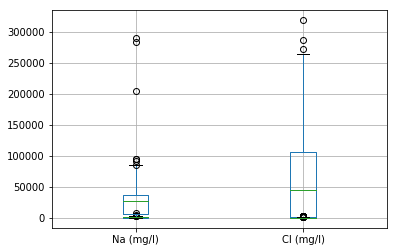

In [13]:
boxplot2 = result.boxplot(column=['Na (mg/l)', 'Cl (mg/l)'])

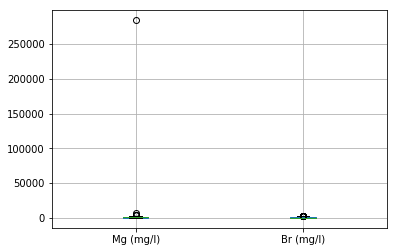

In [14]:
boxplot1 = result.boxplot(column=['Mg (mg/l)', 'Br (mg/l)'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e49c6d8>,
      dtype=object)

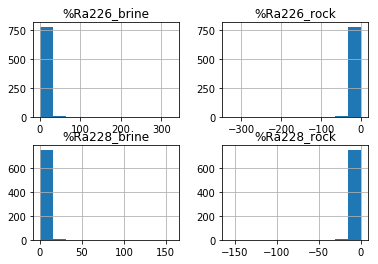

In [9]:
sub_set = result[['%Ra226_brine', '%Ra226_rock', '%Ra228_brine', '%Ra228_rock']]
sub_set.hist(figsize=(6, 4))

In [10]:
"""To better visualize the calculated partitions of brine and rock sources, 
   we first remove outliers from the results, 
   then show histogram plots for individual chemical of interest"""

def remove_source_outliers(string):
    """
    INPUT:
        string - a string of the column name describing %chemical calculated as supplied from one source (e.g. '%Ra226_brine')
    OUTPUT:
        filtered - an array of %chemical with outliers defined and removed
        a histogram of this filtered data is also plotted as an output of this function
    """
    data = np.array(result[string])
    data = data[~np.isnan(data)]
    data = np.asarray([e for e in data if (-5 < e < 5)])*100
    u = np.median(data)
    s = np.std(data)
    filtered = np.asarray([e for e in data if (u-2*s < e < u+2*s)])
    plot1 = plt.hist(filtered, bins = 16,color = 'b')
    plt.xlabel(string)
    plt.ylabel('count')
    plt.show()
    return filtered

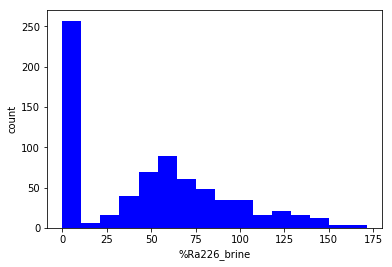

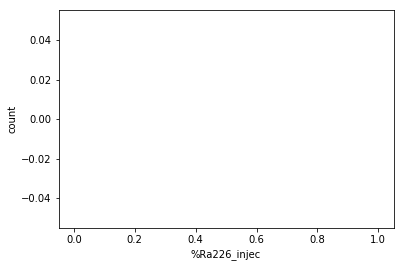

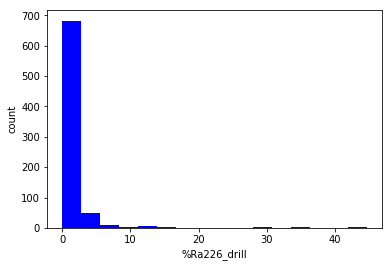

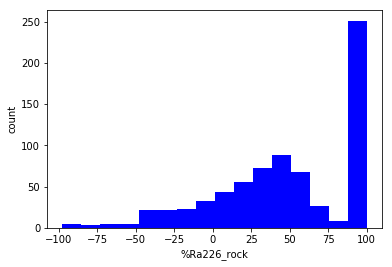

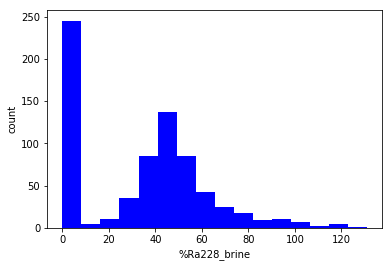

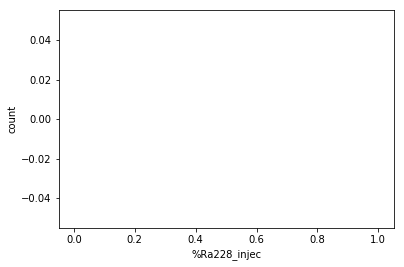

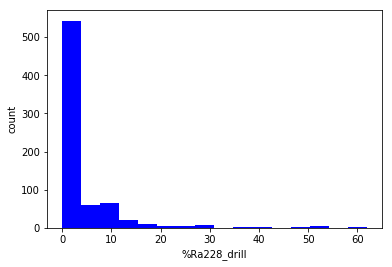

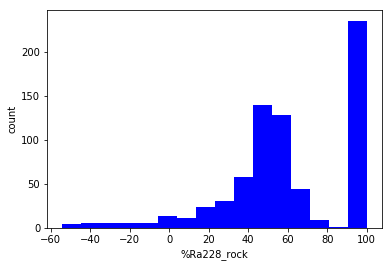

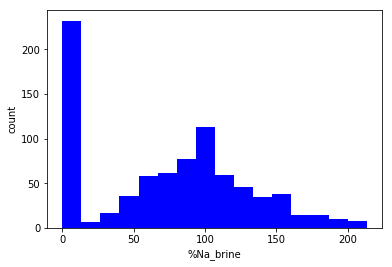

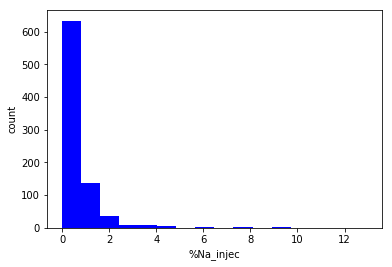

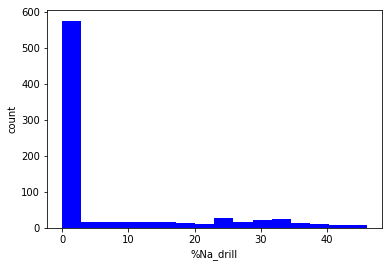

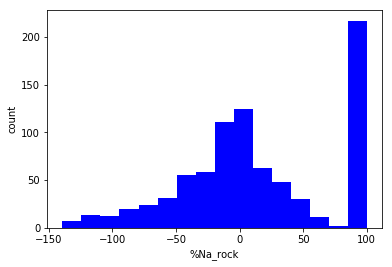

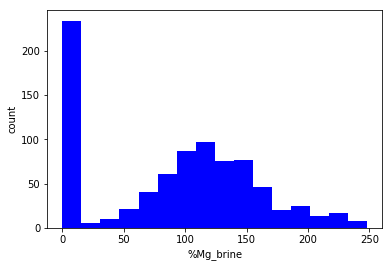

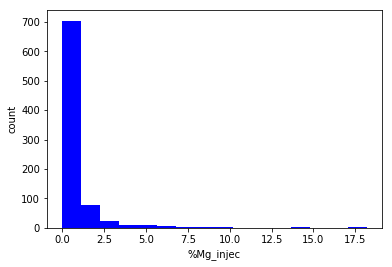

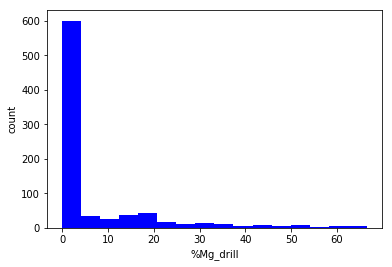

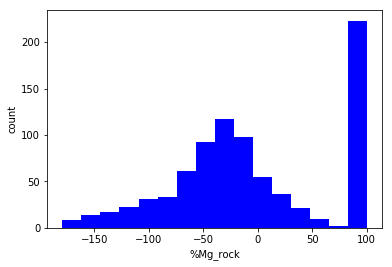

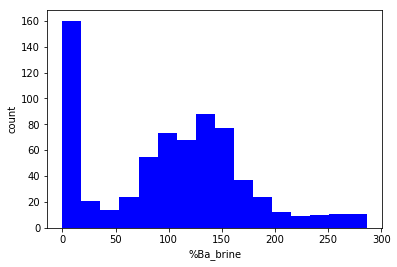

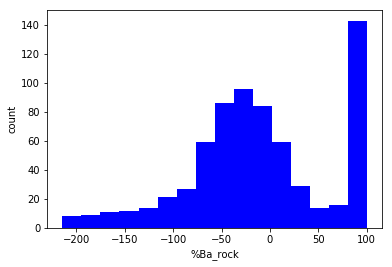

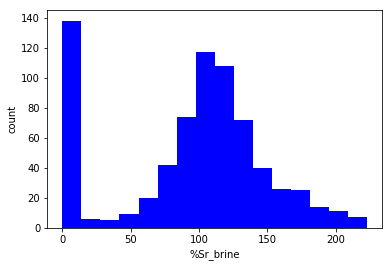

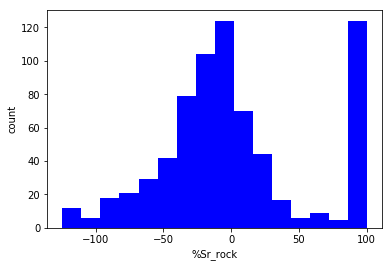

In [11]:
"Explore the distribution of contaminant sources"
Ra226_brine = remove_source_outliers('%Ra226_brine')
Ra226_injec = remove_source_outliers('%Ra226_injec')
Ra226_drill = remove_source_outliers('%Ra226_drill')
Ra226_rock = remove_source_outliers('%Ra226_rock')
Ra228_brine = remove_source_outliers('%Ra228_brine')
Ra228_injec = remove_source_outliers('%Ra228_injec')
Ra228_drill = remove_source_outliers('%Ra228_drill')
Ra228_rock = remove_source_outliers('%Ra228_rock')
Na_brine = remove_source_outliers('%Na_brine')
Na_injec = remove_source_outliers('%Na_injec')
Na_drill = remove_source_outliers('%Na_drill')
Na_rock = remove_source_outliers('%Na_rock')
Mg_brine = remove_source_outliers('%Mg_brine')
Mg_injec = remove_source_outliers('%Mg_injec')
Mg_drill = remove_source_outliers('%Mg_drill')
Mg_rock = remove_source_outliers('%Mg_rock')
Ba_brine = remove_source_outliers('%Ba_brine')
Ba_rock = remove_source_outliers('%Ba_rock')
Sr_brine = remove_source_outliers('%Sr_brine')
Sr_rock = remove_source_outliers('%Sr_rock')

In [ ]:
"""
From various scientific researches, the major sources of contaminants in wastewater include: 
    (1) brine
    (2) rock
And injection and drill fluid do not naturally contain a lot of contaminants (e.g. Ra226, Ra228, Ba, Sr) we are interested in.
"""

In [ ]:
"""
==================================================================
2. Linear Regression:
    Model Selection, Implementation and Validation
    - Can we express proportions of Ra sources with other features of the wastewater?
    - Can we select important features to predict Ra sources?
    - How well can this prediction model do?
"""


In [145]:
"2.1 Pre-treatment of the training & test data"

def set_x_y_s(target, bound, df):
    """
    INPUT:
        target - a string of the column name (e.g. '%Ra226_brine', 'brine_x')
        bound - the upper limit for the chosen target, any values greater than this bound will be filtered out (together with the corresponding attributes)
        df - the dataframe used to generate X and y for prediction operations later
    OUTPUT:
        X - all the features used for prediction model
        y - all the results used for prediction model
    """
    
    data = df.loc[df[target] > 0]
    attributes = df[['Hardness (mg/l)','As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','Gas_quantity','Gas_prod_day','time_collect-spud','Time']]
    predicts = df[[target]]
    names = np.array(['Hardness (mg/l)','As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','Gas_quantity','Gas_prod_day','time_collect-spud','Time'])
    y0 = np.array(predicts.iloc[:, 0])
    size1 = (y0 < bound).sum() 

    X = np.empty([size1, attributes.shape[1]])
    y = np.empty([size1,])   
    j = 0
    for i in range(0,attributes.shape[0]):
        if predicts.loc[i,target] < bound:
            X[j] = np.array(attributes.iloc[i, 0:attributes.shape[1]])
            y[j] = np.array(predicts.iloc[i, 0])
            j = j+1

    X = np.nan_to_num(X)
    y = np.nan_to_num(y)

    return X, y

In [211]:
"2.2 Pre-treatment: remove outliers of selected X and y"

def outlierCleaner(predictions, XX, yy):
    """
    INPUT:
        predictions - all the results generated from prediction model
        XX - all the features used for prediction model
        yy - all the results used for prediction model
    OUTPUT:
        X_cleaned - all the cleaned features used for prediction model
        y_cleaned - all the cleaned results used for prediction model
    """
    
    errors = (yy-predictions)**2
    a0 = XX.shape[1]
    cleaned_data = np.empty([XX.shape[0], a0+2])
    cleaned_data[:,0:a0] = XX
    cleaned_data[:,a0] = yy
    cleaned_data[:,a0+1] = errors
    cleaned_data = sorted(cleaned_data, key = lambda x:x[a0+1], reverse = True)
    limit = int(len(yy)*0.2)
    "Clean away 20% of the points that have the largest residual errors"
    cleaned = cleaned_data[limit:]
    X_cleaned = np.array([e[0:(len(cleaned[0])-2)] for e in cleaned])
    y_cleaned = np.array([e[len(cleaned[0])-2] for e in cleaned])
    return X_cleaned, y_cleaned

In [173]:
"2.3 Use Lasso to search for the important features & try to reduce dimension"

def useLassoSelect(Xtrain,Xtest,ytrain,ytest):
    """
    INPUT:
        Xtrain - all the training set of features used for prediction model
        Xtest - all the test set of features used for prediction model
        ytrain - all the training set of results used for prediction model
        ytest - all the test set of results used for prediction model
    OUTPUT:
        scores_train - a list of training scores
        scores_test - a list of test scores
        coeff_used - a list of feature numbers used for alpha values
        coeffs - a list of coefficient list for all the features
    """
    
    alphas = np.logspace(-10,10,num = 50)
    scores_train = []
    scores_test = []
    coeff_used = []
    coeffs =[]

    for i,a in enumerate(alphas):
        lasso = Lasso()
        lasso.set_params(alpha = a, max_iter = 1e5)
        lasso.fit(Xtrain, ytrain)
        scores_train.append(lasso.score(Xtrain, ytrain))
        scores_test.append(lasso.score(Xtest, ytest))
        coeff_used.append(np.sum(lasso.coef_!=0))
        coeffs.append(lasso.coef_)
        print("Iterate i: {}".format(i))
        print("Training score for alpha = %f is %f" % (a, scores_train[i]))
        print("Test score for alpha = %f is %f" % (a, scores_test[i]))
        print("The number of features used is %d" % (coeff_used[i]))
        
    return scores_train, scores_test, coeff_used, coeffs

In [186]:
"2.4 Test the robustness of pure linear regression"
"Such results may suggest that Ra-226 may not be directly correlated with other elements"

def predict_plot(X,y):
    """
    INPUT:
        X - the set of features used for prediction model
        y - an array of results used for prediction model
    OUTPUT:
        lr_fit - fitted model
        a scatter plot displaying the predicted v.s. measured results
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.4, random_state=123456)

    lr = linear_model.LinearRegression()
    lr_fit = lr.fit(X_train, y_train)
    lr_train_score = lr.score(X_train,y_train)
    lr_test_score = lr.score(X_test,y_test)

    print("Linear regression training score is %f" % (lr_train_score))
    print("Linear regression test score is %f" % (lr_test_score))
    print("Linear regression whole score is %f" % (lr.score(X,y)))

    "Plot the results of this fit for the complete dataset"

    preds = lr_fit.predict(X)

    fig, ax = plt.subplots()
    ax.scatter(y, preds, edgecolors = (0,0,0))
    ax.plot([y.min(),y.max()], [y.min(),y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

    print("Mean square error is %f" % (mean_squared_error(preds,y)))
    print("R-square is %f" % (r2_score(preds,y)))
    
    return lr_fit

In [212]:
"2.5 Run models on results to our interest"
"2.5.1 run prediction model on %Ra226_brine:"

"i) Decide on initial X & y values for prediction model"
target = '%Ra226_brine'
bound = 1.45
X, y = set_x_y_s(target,bound,result)

"ii) Clean up outliers to prepare for better prediction"
lr = linear_model.LinearRegression()
lr.fit(X, y)
X_cleaned, y_cleaned = outlierCleaner(lr.predict(X), X, y)

"iii) Use Lasso method to select the best parameters for prediction model"
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.4, random_state=123456)
scores_train, scores_test, coeff_used, coeffs = useLassoSelect(X_train,X_test,y_train,y_test)

"""iv) As a result, we determine the best parameters should be:
    - i = 25
    - alpha = 1.599859,
    - number of features = 18,
    with training_score = 0.952790, and test_score = 0.942377.
"""

/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


Iterate i: 0
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867107
The number of features used is 31
Iterate i: 1
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867106
The number of features used is 31
Iterate i: 2
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867106
The number of features used is 31
Iterate i: 3
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867105
The number of features used is 31
Iterate i: 4
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867104
The number of features used is 31
Iterate i: 5
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867099
The number of features used is 31
Iterate i: 6
Training score for alpha = 0.000000 is 0.960007
Test score for alpha = 0.000000 is -13.867088
The number of features used is 31
Iterate i: 7


'iv) As a result, we determine the best parameters should be:\n    - alpha = 0.625055,\n    - number of features = 19,\n    with training_score = 0.935622, and test_score = 0.930342.\n'

The dimension of new X with selected features is (716, 18)
Linear regression training score is 0.775057
Linear regression test score is 0.685500
Linear regression whole score is 0.738188


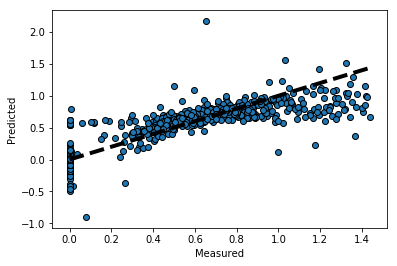

Mean square error is 0.044831
R-square is 0.684240


In [213]:
"Create new X with selected features from steps i - iii"
size = np.sum(coeffs[25]!=0)
X_new = np.empty([X.shape[0], size])

names = np.array(['Hardness (mg/l)','As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','Gas_quantity','Gas_prod_day','time_collect-spud','Time'])

j = 0
for i,a in enumerate(coeffs[25]):
    if coeffs[25][i] != 0:
        X_new[:, j] = X[:, i]
        j += 1

"Check out dimension of the new X, fit on the selected features, then plot results"
print("The dimension of new X with selected features is {}".format(X_new.shape))
clf = predict_plot(X_new, y)

In [214]:
"2.5.2 run prediction model on %Ra228_brine:"

"i) Decide on initial X & y values for prediction model"
target = '%Ra228_brine'
bound = 1.45
X, y = set_x_y_s(target,bound,result)

"ii) Clean up outliers to prepare for better prediction"
lr = linear_model.LinearRegression()
lr.fit(X, y)
X_cleaned, y_cleaned = outlierCleaner(lr.predict(X), X, y)

"iii) Use Lasso method to select the best parameters for prediction model"
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.4, random_state=123456)
scores_train, scores_test, coeff_used, coeffs = useLassoSelect(X_train,X_test,y_train,y_test)

"""iv) As a result, we determine the best parameters should be:
    - i = 12
    - alpha = 0.000008,
    - number of features = 31,
    with training_score = 0.946490, and test_score = 0.931208.
"""

/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


Iterate i: 0
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 1
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 2
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 3
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 4
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 5
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 6
Training score for alpha = 0.000000 is 0.946490
Test score for alpha = 0.000000 is 0.931208
The number of features used is 31
Iterate i: 7
Training score

'iv) As a result, we determine the best parameters should be:\n    - alpha = 0.625055,\n    - number of features = 17,\n    with training_score = 0.926800, and test_score = 0.895977.\n'

The dimension of new X with selected features is (730, 22)
Linear regression training score is 0.671114
Linear regression test score is 0.576490
Linear regression whole score is 0.636358


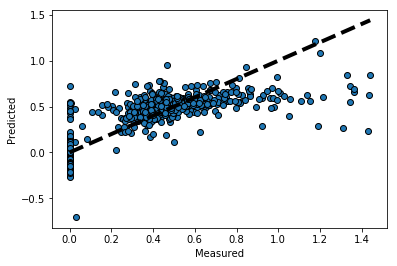

Mean square error is 0.033474
R-square is 0.475074


In [216]:
"Create new X with selected features from steps i - iii"
size = np.sum(np.absolute(coeffs[12])>0.000001)
X_new = np.empty([X.shape[0], size])

names = np.array(['Hardness (mg/l)','As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','Gas_quantity','Gas_prod_day','time_collect-spud','Time'])

j = 0
for i,a in enumerate(coeffs[12]):
    if np.absolute(coeffs[12][i])>0.000001:
        X_new[:, j] = X[:, i]
        j += 1

"Check out dimension of the new X, fit on the selected features, then plot results"
print("The dimension of new X with selected features is {}".format(X_new.shape))
clf = predict_plot(X_new, y)

In [217]:
"2.5.3 run prediction model on %Ba_brine:"

"i) Decide on initial X & y values for prediction model"
target = '%Ba_brine'
bound = 2.0
X, y = set_x_y_s(target,bound,result)

"ii) Clean up outliers to prepare for better prediction"
lr = linear_model.LinearRegression()
lr.fit(X, y)
X_cleaned, y_cleaned = outlierCleaner(lr.predict(X), X, y)

"iii) Use Lasso method to select the best parameters for prediction model"
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.4, random_state=123456)
scores_train, scores_test, coeff_used, coeffs = useLassoSelect(X_train,X_test,y_train,y_test)

"""iv) As a result, we determine the best parameters should be:
    - i = 29
    - alpha = 68.664885,
    - number of features = 13,
    with training_score = 0.921351, and test_score = 0.860085.
"""

/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


Iterate i: 0
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025376
The number of features used is 31
Iterate i: 1
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025376
The number of features used is 31
Iterate i: 2
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025376
The number of features used is 31
Iterate i: 3
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025376
The number of features used is 31
Iterate i: 4
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025375
The number of features used is 31
Iterate i: 5
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025375
The number of features used is 31
Iterate i: 6
Training score for alpha = 0.000000 is 0.954807
Test score for alpha = 0.000000 is -0.025375
The number of features used is 31
Iterate i: 7
Trainin

'iv) As a result, we determine the best parameters should be:\n    - alpha = 0.000000,\n    - number of features = 31,\n    with training_score = 0.930124, and test_score = 0.918845.\n'

The dimension of new X with selected features is (645, 13)
Linear regression training score is 0.674648
Linear regression test score is -387.809578
Linear regression whole score is -155.303272


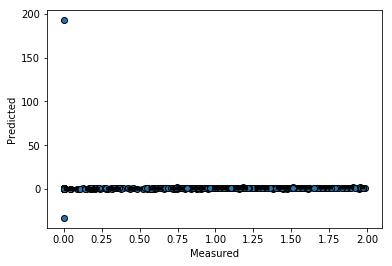

Mean square error is 59.307918
R-square is -0.006245


In [221]:
"Create new X with selected features from steps i - iii"
size = np.sum(coeffs[29]!=0)
X_new = np.empty([X.shape[0], size])

names = np.array(['Hardness (mg/l)','As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','Gas_quantity','Gas_prod_day','time_collect-spud','Time'])

j = 0
for i,a in enumerate(coeffs[29]):
    if coeffs[29][i] != 0:
        X_new[:, j] = X[:, i]
        j += 1

"Check out dimension of the new X, fit on the selected features, then plot results"
print("The dimension of new X with selected features is {}".format(X_new.shape))
clf = predict_plot(X_new, y)

In [222]:
"2.5.4 run prediction model on %Sr_brine:"

"i) Decide on initial X & y values for prediction model"
target = '%Sr_brine'
bound = 2.0
X, y = set_x_y_s(target,bound,result)

"ii) Clean up outliers to prepare for better prediction"
lr = linear_model.LinearRegression()
lr.fit(X, y)
X_cleaned, y_cleaned = outlierCleaner(lr.predict(X), X, y)

"iii) Use Lasso method to select the best parameters for prediction model"
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.4, random_state=123456)
scores_train, scores_test, coeff_used, coeffs = useLassoSelect(X_train,X_test,y_train,y_test)

"""iv) As a result, none of the parameters are good for linear regression model
"""

/Users/bingjieouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


Iterate i: 0
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163536
The number of features used is 31
Iterate i: 1
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163530
The number of features used is 31
Iterate i: 2
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163515
The number of features used is 31
Iterate i: 3
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163475
The number of features used is 31
Iterate i: 4
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163374
The number of features used is 31
Iterate i: 5
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.163117
The number of features used is 31
Iterate i: 6
Training score for alpha = 0.000000 is 0.914465
Test score for alpha = 0.000000 is -1148.162457
The number of features used is 31

'iv) As a result, we determine the best parameters should be:\n    - i = 29\n    - alpha = 68.664885,\n    - number of features = 13,\n    with training_score = 0.921351, and test_score = 0.860085.\n'

In [ ]:
"""
2.6. Summary of linear regression model for prediction:
    Linear regression model does not seem to generate good scores for prediction.
    The poor prediction suggests the sources of contaminants Ra226, Ra228, Ba, and Sr are not necessarily correlated with concentrations of other chemicals.
    The processes of fluid mixing and water-rock interaction might be independent from the input process of high chemical concentrations.
"""

In [ ]:
"""
==================================================================
3. Classification: 
    Model Selection, Implementation and Validation
    - Goal is to predict whether the net change of an element in the calculated process is from rock or goes to rock?
    - Select important features that associate with such prediction/classification
"""

In [15]:
"""3.1 Define the target dataframe"""
def full_target(data, target):
    """
    INPUT:
        data - the dataframe to extract all features from (e.g. result)
        target - the column of results based on which we want to perform classification (e.g. %Ra226_rock)
    OUTPUT:
        new_data - the new dataframe with all features and valid target values
        y - classification results to be used for prediction model
    """
    
    new_data = data[data[target].isnull()==False].reset_index(drop=True)
    
    y = np.empty([new_data.shape[0],])
    "if % of target element from the source > 0, it is supplied by the source; otherwise, it is not"
    for k in range(0,new_data.shape[0]):
        if new_data.loc[k,target] > 0:
            y[k] = 1 
            "supplied by this source (e.g. rock)"
        else:
            y[k] = 0 
            "not supplied (or goes to) this source"
    
    return new_data, y

In [16]:
"""3.2 Select important features"""
def select_features(data, names, y):
    """
    INPUT:
        data - the dataframe to extract all features from (e.g. result)
        names - a list of the name of all used attributes
        y - a list of classification results generated from 'full_target(data, target)' function
    OUTPUT:
        indices - the calculated importances for all features
        a bar plot showing the calculated importances for all features
    """
    
    number = 100
    index = names.shape[0]
    X = np.array(data[names])
    importances = np.empty((number,index))
    clf=ExtraTreesClassifier()
    "Calculate importances for 100 times repeatedly"
    for i in range(0,number):
        clf=clf.fit(X,y)
        importances[i,:] = clf.feature_importances_
    "Get the mean of the repeated calculations for all features"
    importance2 = np.empty((2,index))
    for j in range(0,index):
        importance2[0,j] = np.mean(importances[:,j])
        importance2[1,j] = np.std(importances[:,j])
    "Rank the calculated importances for all features"
    indices = np.argsort(importance2[0,:])[::-1]
    print("Feature rankings:")
    for f in range(X.shape[1]):
        print("%d. feature %d [%s] is (%f)" % (f+1, indices[f], names[indices[f]], importance2[0,indices[f]]))
        
    "Plot the average feature importance2"
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importance2[0,indices], color = "c", yerr=importance2[1,indices], align = "center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    return indices

In [21]:
names = np.array(['As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Hardness (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','pH','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','time_collect-spud','Gas_quantity'])

for i, a in enumerate(names):
    print('{}-{}'.format(i, a))

0-As (mg/l)
1-B (mg/l)
2-Ba (mg/l)
3-Ca (mg/l)
4-Cu (mg/l)
5-Fe (mg/l)
6-Li (mg/l)
7-Mg (mg/l)
8-Mn (mg/l)
9-Na (mg/l)
10-Se (mg/l)
11-Sr (mg/l)
12-Zn (mg/l)
13-Hardness (mg/l)
14-Alkalinity (mgCaCO3/l)
15-Br (mg/l)
16-Cl (mg/l)
17-COD (mg/l)
18-Specific conductance (umhos/cm)
19-pH
20-TDS (mg/l)
21-TSS (mg/l)
22-Gross a (pCi/L or g)
23-Gross b (pCi/L or g)
24-Ra-226 (pCi/L or g)
25-Ra-228 (pCi/L or g)
26-Well_latitude
27-Well_longitude
28-time_collect-spud
29-Gas_quantity


Feature rankings:
1. feature 24 [Ra-226 (pCi/L or g)] is (0.118029)
2. feature 16 [Cl (mg/l)] is (0.077996)
3. feature 27 [Well_longitude] is (0.063835)
4. feature 19 [pH] is (0.042516)
5. feature 26 [Well_latitude] is (0.041463)
6. feature 15 [Br (mg/l)] is (0.037055)
7. feature 23 [Gross b (pCi/L or g)] is (0.034505)
8. feature 22 [Gross a (pCi/L or g)] is (0.033535)
9. feature 18 [Specific conductance (umhos/cm)] is (0.033490)
10. feature 28 [time_collect-spud] is (0.031890)
11. feature 8 [Mn (mg/l)] is (0.031731)
12. feature 6 [Li (mg/l)] is (0.029979)
13. feature 2 [Ba (mg/l)] is (0.029806)
14. feature 14 [Alkalinity (mgCaCO3/l)] is (0.029175)
15. feature 9 [Na (mg/l)] is (0.028884)
16. feature 13 [Hardness (mg/l)] is (0.027302)
17. feature 20 [TDS (mg/l)] is (0.027013)
18. feature 3 [Ca (mg/l)] is (0.026938)
19. feature 11 [Sr (mg/l)] is (0.026915)
20. feature 25 [Ra-228 (pCi/L or g)] is (0.026827)
21. feature 12 [Zn (mg/l)] is (0.026482)
22. feature 29 [Gas_quantity] is (0.02571

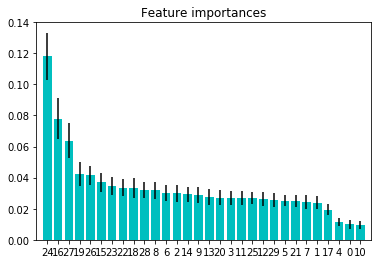

In [270]:
"3.3 Classification on Ra226 sourced from rocks"

"i) Pre-process to select important features"

full_Ra226, y = full_target(result, '%Ra226_rock')
names = np.array(['As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Hardness (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','pH','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','time_collect-spud','Gas_quantity'])
indices = select_features(full_Ra226,names,y)

In [297]:
"ii) Create new X attributes using 20 features instead of 31"
New_X = np.empty((full_Ra226.shape[0], 20))
for i,a in enumerate(indices[:20]):
    New_X[:, i] = full_Ra226.loc[:, names[a]]

"Split X & y values, then scale X attributes:"
X_train, X_test, y_train, y_test = train_test_split(New_X,y , test_size = 0.2, random_state=123456)
X_train_s = preprocessing.scale(X_train)
X_test_s = preprocessing.scale(X_test)


In [298]:
"iii) Tune parameters"
dt = tree.DecisionTreeClassifier()
param_grid = {"max_depth": [2,4,6,8,10,12,14,16,18,20], "max_leaf_nodes": [25,30,35,40,45,50,55,60,65,70,75,80]}
clf_dt = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 10)
clf_dt.fit(X_train_s, y_train)
print(clf_dt.best_params_)
print(clf_dt.best_score_)

{'max_depth': 10, 'max_leaf_nodes': 60}
0.9044585987261147


In [299]:
"iv) Use the best parameters as dt to test accuracy with cross validation"
"The better values are max_depth = 10, max_leaf_nodes = 60"
dt = tree.DecisionTreeClassifier(max_depth = 10, max_leaf_nodes = 60)
dt_fit = dt.fit(X_train_s, y_train)

scores = cross_val_score(dt, X_train_s, y_train, cv = 5, scoring = 'accuracy')
print("Training accuracy (with cv) is %0.3f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))
y_pred = dt_fit.predict(X_train_s)
print("Training accuracy (no cv) is %0.3f" % (accuracy_score(y_pred,y_train)*100))

preds = cross_val_predict(dt, X_test_s, y_test, cv = 5)
print("Test accuracy (with cv) is %0.3f" % (accuracy_score(y_test, preds)*100))
print("Test accuracy (no cv) is %0.3f" % (dt_fit.score(X_test_s,y_test)*100))

Training accuracy (with cv) is 87.894 (+/- 3.40)
Training accuracy (no cv) is 100.000
Test accuracy (with cv) is 76.433
Test accuracy (no cv) is 83.439


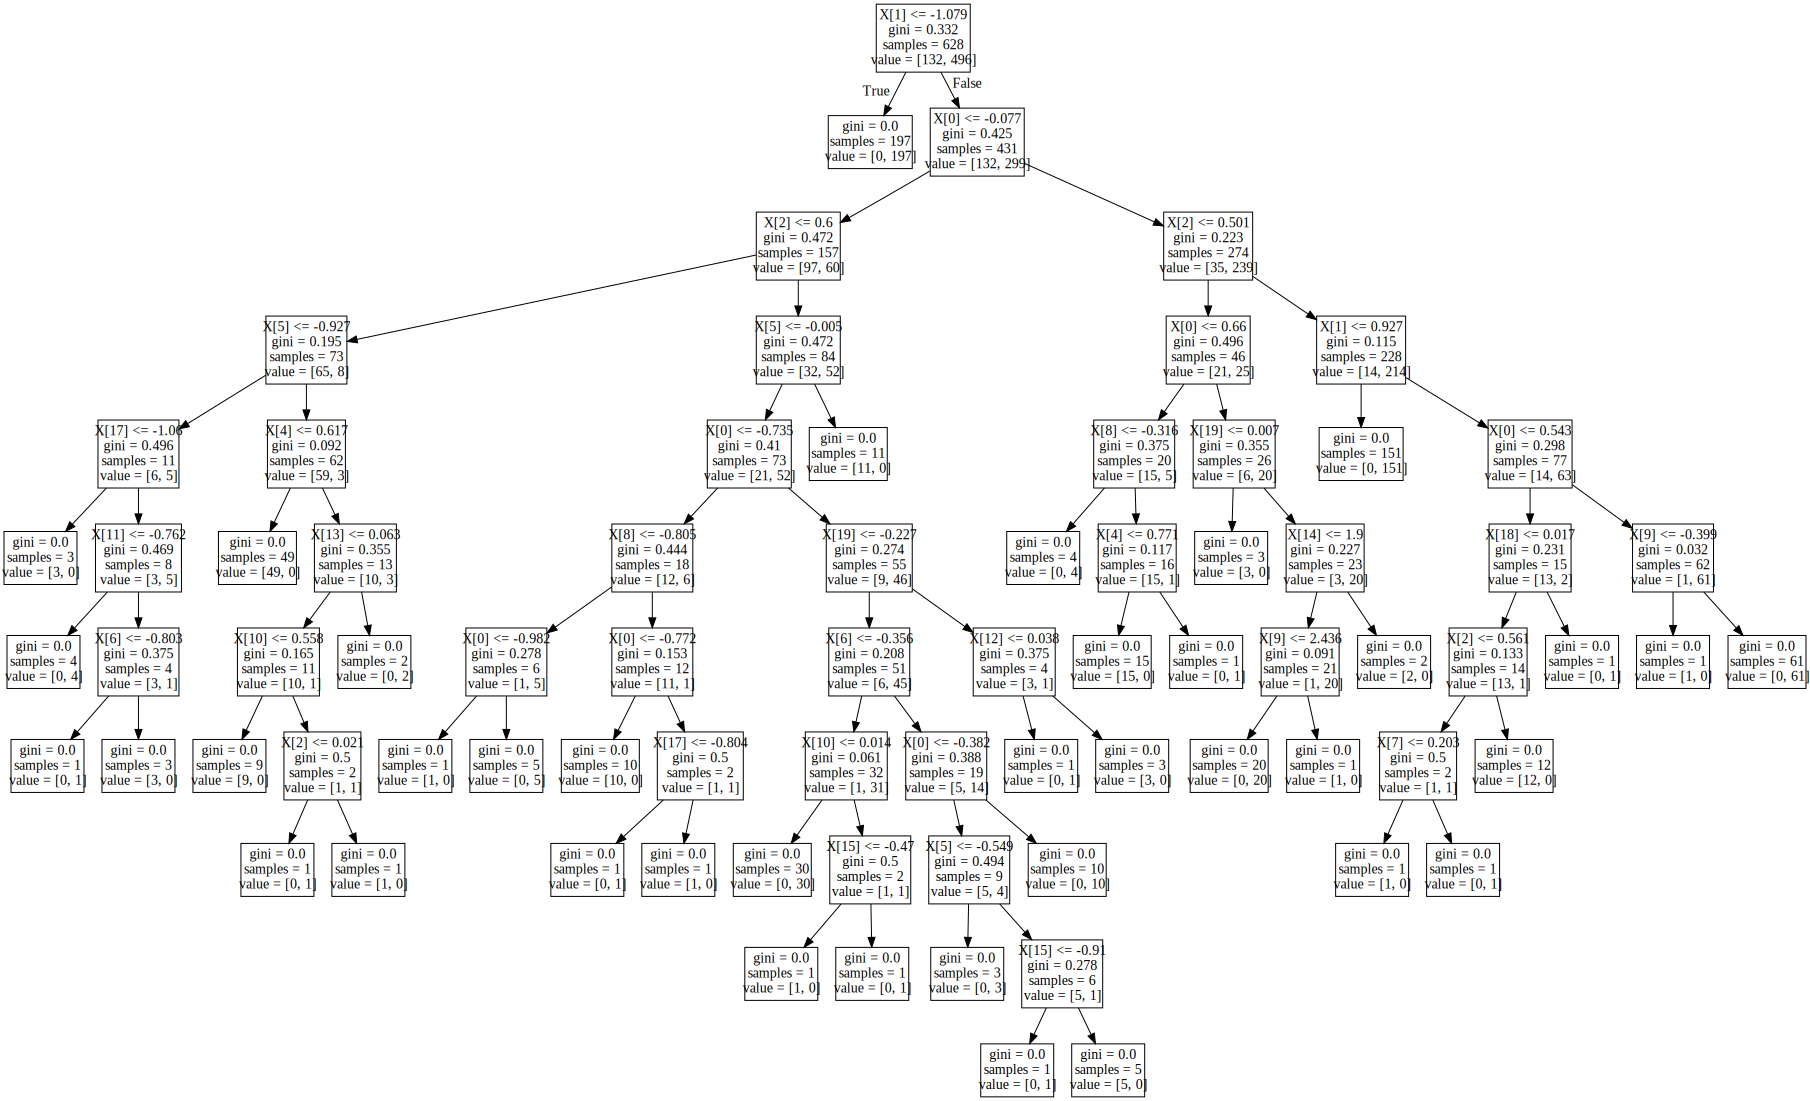

In [300]:
"v) Plot out the tuned decision tree results to see how it proceeds"
dot_data = tree.export_graphviz(dt_fit, out_file = None)
graph = graphviz.Source(dot_data)
graph

Feature rankings:
1. feature 16 [Cl (mg/l)] is (0.084057)
2. feature 27 [Well_longitude] is (0.082976)
3. feature 25 [Ra-228 (pCi/L or g)] is (0.047296)
4. feature 18 [Specific conductance (umhos/cm)] is (0.044143)
5. feature 19 [pH] is (0.042893)
6. feature 21 [TSS (mg/l)] is (0.038987)
7. feature 26 [Well_latitude] is (0.034573)
8. feature 17 [COD (mg/l)] is (0.033206)
9. feature 14 [Alkalinity (mgCaCO3/l)] is (0.032329)
10. feature 12 [Zn (mg/l)] is (0.032012)
11. feature 29 [Gas_quantity] is (0.031751)
12. feature 4 [Cu (mg/l)] is (0.031368)
13. feature 11 [Sr (mg/l)] is (0.031148)
14. feature 2 [Ba (mg/l)] is (0.031134)
15. feature 6 [Li (mg/l)] is (0.030998)
16. feature 3 [Ca (mg/l)] is (0.030658)
17. feature 9 [Na (mg/l)] is (0.030276)
18. feature 23 [Gross b (pCi/L or g)] is (0.029236)
19. feature 28 [time_collect-spud] is (0.028568)
20. feature 5 [Fe (mg/l)] is (0.026557)
21. feature 13 [Hardness (mg/l)] is (0.026117)
22. feature 15 [Br (mg/l)] is (0.025335)
23. feature 0 [As 

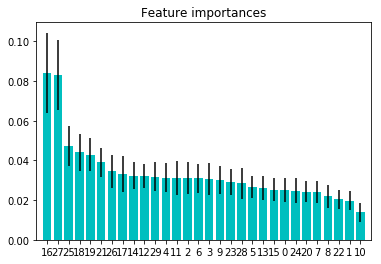

In [301]:
"3.4 Classification on Ra228 sourced from rocks"

"i) Pre-process to select important features"

full_Ra228, y = full_target(result, '%Ra228_rock')
names = np.array(['As (mg/l)','B (mg/l)','Ba (mg/l)','Ca (mg/l)','Cu (mg/l)','Fe (mg/l)','Li (mg/l)','Mg (mg/l)','Mn (mg/l)','Na (mg/l)','Se (mg/l)','Sr (mg/l)','Zn (mg/l)','Hardness (mg/l)','Alkalinity (mgCaCO3/l)','Br (mg/l)','Cl (mg/l)','COD (mg/l)','Specific conductance (umhos/cm)','pH','TDS (mg/l)','TSS (mg/l)','Gross a (pCi/L or g)','Gross b (pCi/L or g)','Ra-226 (pCi/L or g)','Ra-228 (pCi/L or g)','Well_latitude','Well_longitude','time_collect-spud','Gas_quantity'])
indices = select_features(full_Ra228,names,y)

In [302]:
"ii) Create new X attributes using 20 features instead of 31"
New_X = np.empty((full_Ra228.shape[0], 20))
for i,a in enumerate(indices[:20]):
    New_X[:, i] = full_Ra228.loc[:, names[a]]

"Split X & y values, then scale X attributes:"
X_train, X_test, y_train, y_test = train_test_split(New_X,y , test_size = 0.2, random_state=123456)
X_train_s = preprocessing.scale(X_train)
X_test_s = preprocessing.scale(X_test)


In [303]:
"iii) Tune parameters"
dt = tree.DecisionTreeClassifier()
param_grid = {"max_depth": [2,4,6,8,10,12,14,16,18,20], "max_leaf_nodes": [25,30,35,40,45,50,55,60,65,70,75,80]}
clf_dt = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 10)
clf_dt.fit(X_train_s, y_train)
print(clf_dt.best_params_)
print(clf_dt.best_score_)

{'max_depth': 16, 'max_leaf_nodes': 25}
0.9362745098039216


In [304]:
"iv) Use the best parameters as dt to test accuracy with cross validation"
"The better values are max_depth = 16, max_leaf_nodes = 25"
dt = tree.DecisionTreeClassifier(max_depth = 16, max_leaf_nodes = 25)
dt_fit = dt.fit(X_train_s, y_train)

scores = cross_val_score(dt, X_train_s, y_train, cv = 5, scoring = 'accuracy')
print("Training accuracy (with cv) is %0.3f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))
y_pred = dt_fit.predict(X_train_s)
print("Training accuracy (no cv) is %0.3f" % (accuracy_score(y_pred,y_train)*100))

preds = cross_val_predict(dt, X_test_s, y_test, cv = 5)
print("Test accuracy (with cv) is %0.3f" % (accuracy_score(y_test, preds)*100))
print("Test accuracy (no cv) is %0.3f" % (dt_fit.score(X_test_s,y_test)*100))

Training accuracy (with cv) is 93.465 (+/- 1.25)
Training accuracy (no cv) is 99.673
Test accuracy (with cv) is 86.275
Test accuracy (no cv) is 77.778


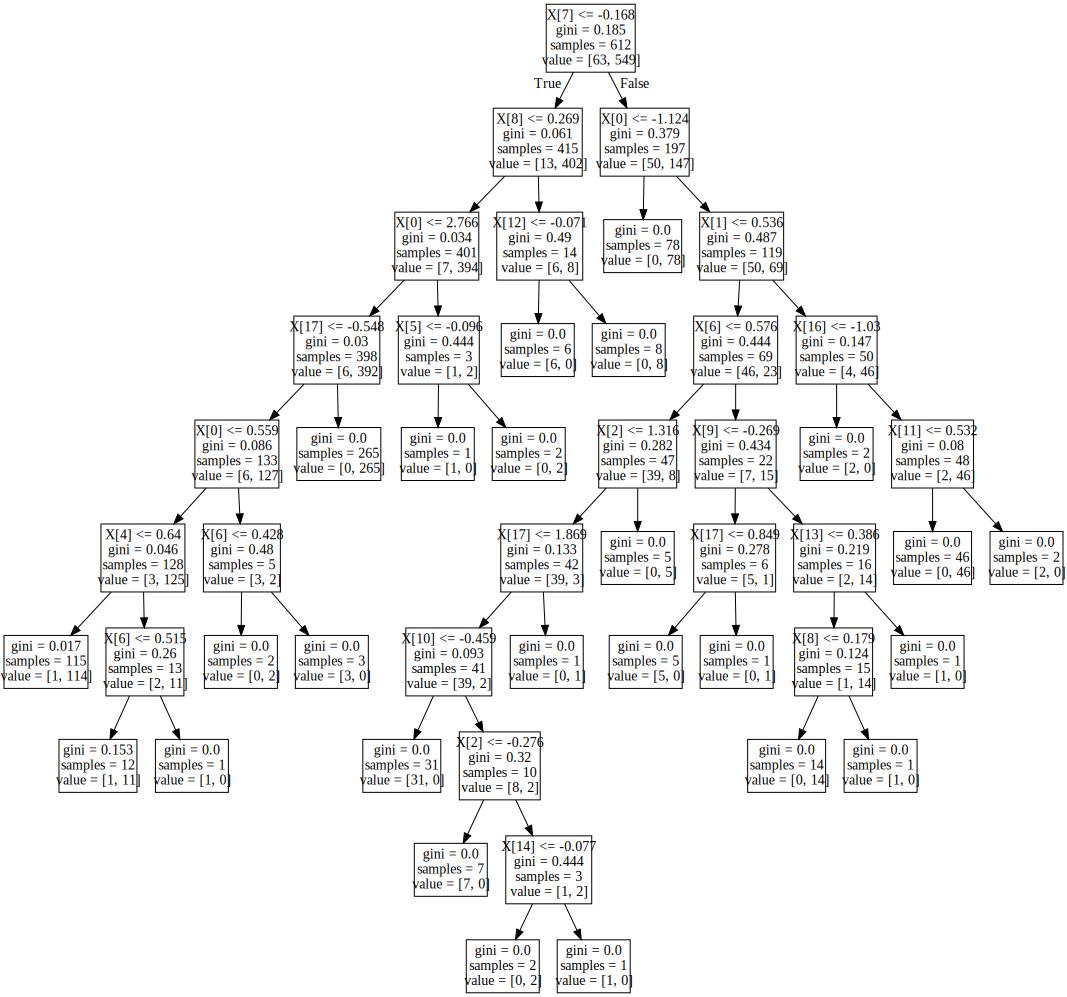

In [305]:
"v) Plot out the tuned decision tree results to see how it proceeds"
dot_data = tree.export_graphviz(dt_fit, out_file = None)
graph = graphviz.Source(dot_data)
graph